## Inference Notebook with Model performance testing and Functions for testing photos and to livestream via webcam


**Expected to be run on Google Colab only**

In [1]:
import os
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import plotly.express as px
import matplotlib.pyplot as plt
import tensorflow.data as tfds
from sklearn.model_selection import train_test_split
from keras.applications import VGG16
from keras.applications import Xception, InceptionV3
from keras.applications import ResNet50V2, ResNet152V2
from keras.applications import MobileNetV3Small, MobileNetV3Large
from keras import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten, GlobalAveragePooling2D
from keras.layers import InputLayer
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
!pip install mtcnn
import cv2
from PIL import Image
import numpy as np
from mtcnn import MTCNN
import tensorflow as tf
from keras.models import load_model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 8.0 MB/s eta 0:00:00


In [2]:
np.random.seed(42)
tf.random.set_seed(42)
BATCH_SIZE = 32
IMAGE_SIZE = 224

In [3]:
detector = MTCNN()

## **Load the models by giving the model path here.**

In [4]:
age_net_utk = load_model('/content/drive/MyDrive/MLGC24/Models/Age_net_UTK.h5')
age_net_augment = load_model('/content/drive/MyDrive/MLGC24/Models/Age_net_Augment.h5')
gen_net_utk = load_model('/content/drive/MyDrive/MLGC24/Models/Gen_net_UTK.h5')

## First let's test the model performance on 25% of UTK Dataset

In [5]:
dir_path = "/content/drive/MyDrive/MLGC24/UTKFace/"  #Give path to the sub folder UTK Face not the main folder
image_paths = os.listdir(dir_path)

lst = list()
for file in image_paths:
  if file.endswith('.jpg'):
    lst.append(file)
image_paths = lst

gender_mapping = ["Male", "Female"]

print(f"Total number of images  : {len(image_paths)}")

Total number of images  : 23708


In [11]:
np.random.shuffle(image_paths)

train_images, test_images = train_test_split(
    image_paths,
    train_size = 0.75,
    test_size = 0.25
)
print(f"Testing Size  : {len(test_images)}")
test_ages = [int(path.split("_")[0]) for path in test_images]
test_genders = [int(path.split("_")[1]) for path in test_images]

Testing Size  : 5927


**Utils**

In [12]:
def show_image(image, show=False):
    plt.imshow(image)
    plt.axis("off")
    if show:
        plt.show()

def preprocess_age_data(image_path, age, gender, dir_path=dir_path, IMAGE_SIZE = IMAGE_SIZE):
    image = tf.io.read_file(dir_path + image_path)
    image = tf.io.decode_jpeg(image)
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = image / 255.
    image = tf.cast(image, tf.float32)
    return image, age

def preprocess_gender_data(image_path, age, gender, dir_path=dir_path, IMAGE_SIZE = IMAGE_SIZE):
    image = tf.io.read_file(dir_path + image_path)
    image = tf.io.decode_jpeg(image)
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = image / 255.
    image = tf.cast(image, tf.float32)
    return image, gender

In [13]:
test_ds  = tfds.Dataset.from_tensor_slices((test_images, test_ages, test_genders)).shuffle(500)
test_age_ds = test_ds.map(preprocess_age_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)
test_gender_ds = test_ds.map(preprocess_gender_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)

### AGE Estimation of VGG 16 model trained on Augmented Dataset of UTK and facial age cropped images

In [14]:
age_net_augment.compile(loss='mean_squared_error', optimizer='adam')
mse = age_net_augment.evaluate(test_age_ds)
age_net_augment.compile(loss='mae', optimizer='adam')
mae = age_net_augment.evaluate(test_age_ds)
print( mae , mse )

186/186 [==============================] - 23s 124ms/step - loss: 5.6144
5.614386558532715 67.24980163574219


### AGE Estimation of VGG 16 model trained on UTK original

In [15]:
age_net_utk.compile(loss='mean_squared_error', optimizer='adam')
mse = age_net_utk.evaluate(test_age_ds)
age_net_utk.compile(loss='mae', optimizer='adam')
mae = age_net_utk.evaluate(test_age_ds)
print( mae , mse )

186/186 [==============================] - 24s 128ms/step - loss: 5.8892
5.889223098754883 74.64266967773438


## Gender Classification by Resnet 152V2 trained on UTK original

In [16]:
gen_net_utk.evaluate(test_gender_ds)

186/186 [==============================] - 49s 228ms/step - loss: 0.2611 - accuracy: 0.8883


[0.2610589265823364, 0.8883077502250671]

# Hence our Final models will be
## Age: VGG 16 trained on UTK + Facial age augmented dataset  **MAE: 5.614 MSE: 67.2498**
## Gender: Resnet152v2 trained on UTK original dataset **Loss: 0.26105 Accuracy: 0.88831**

## **Sample Analysis**

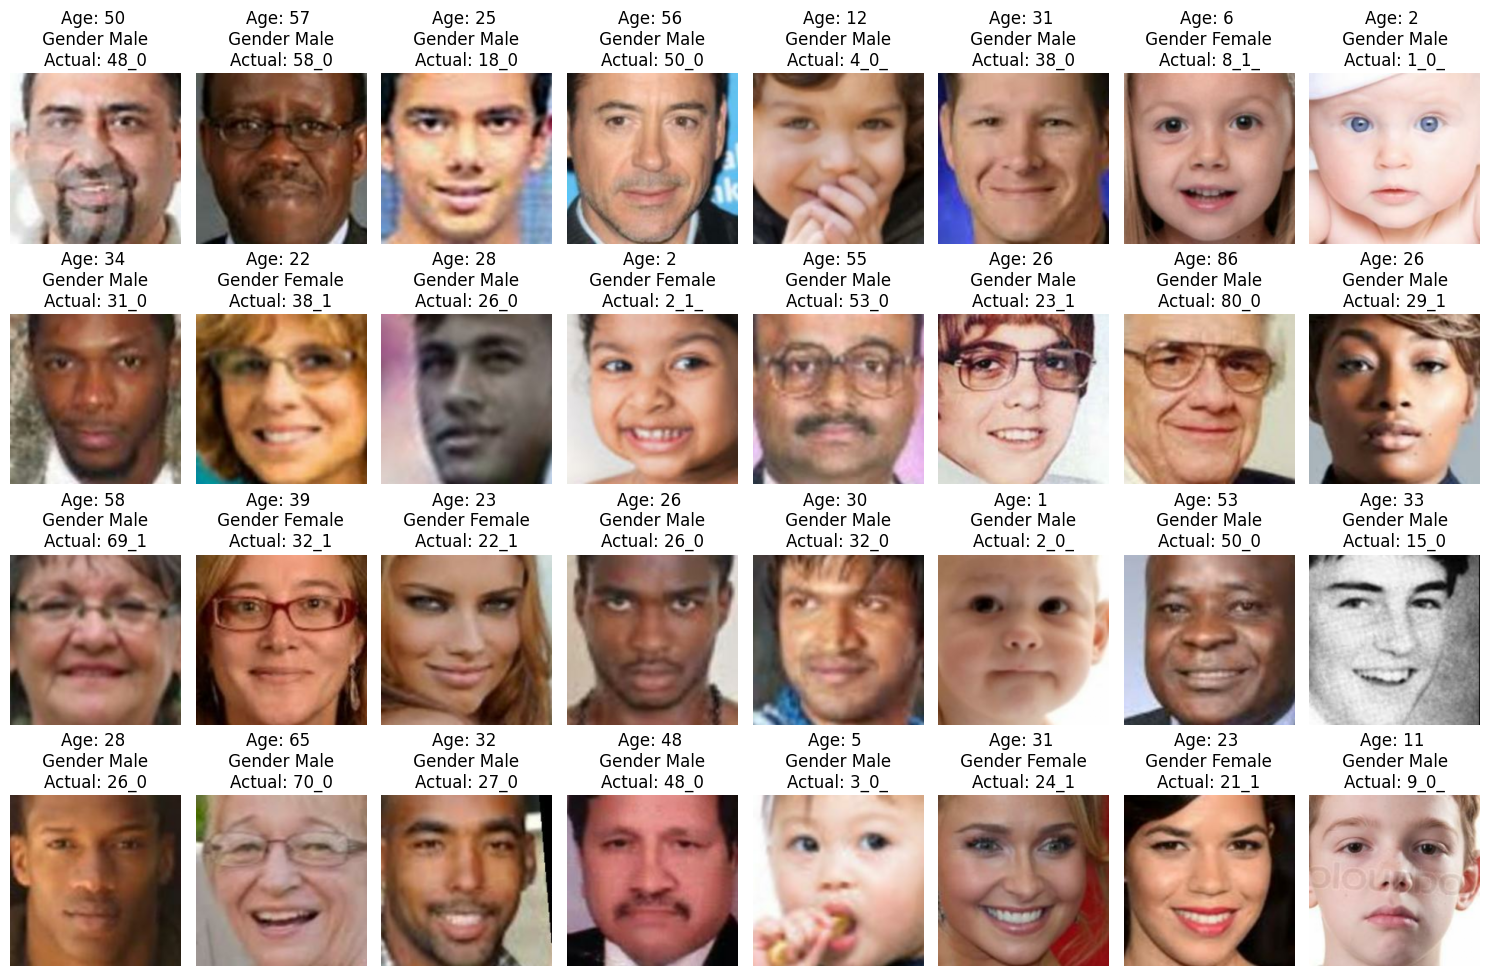

In [17]:
plt.figure(figsize=(15, 10))
for images, ages, genders in test_ds.batch(BATCH_SIZE).take(1):
    for index in range(len(images)):
        image = tf.io.read_file(dir_path + images[index])
        image = tf.io.decode_jpeg(image)
        image = tf.cast(image, tf.float32)
        image = image/255.
        image = tf.image.resize(image, [224,224])
        image = tf.reshape(image, [-1,224,224,3])
        # b,g,r = tf.split(image, num_or_size_splits=3, axis=-1)
        # image = tf.concat([r,g,b], axis=-1)
        # Predictions
        pred_age = tf.round(tf.squeeze(age_net_augment.predict(image, verbose=0)), 2)
        pred_gender = gender_mapping[ int(tf.round(tf.squeeze(gen_net_utk.predict(image, verbose=0)), 2))]
        string_value = images[index].numpy().decode('utf-8')
        ftc = string_value[:4]
        # Visualization
        plt.subplot(4, 8, index + 1)
        plt.imshow(image[0])
        plt.title(f"Age: {int(pred_age)} \n Gender { pred_gender } \nActual: {ftc}")
        plt.axis("off")

plt.tight_layout()
plt.show()

## **Function to use for Precropped images to the level of forehead to chin, input is the file path**

In [11]:
def find_age_gender_precropped( img_path ): #entire image path to be given
  gender_mapping = ["Male", "Female"]
  image = tf.io.read_file(img_path)
  image = tf.io.decode_jpeg(image)
  image = tf.cast(image, tf.float32)
  image = image/255.
  image = tf.image.resize(image, [224,224])
  image = tf.reshape(image, [-1,224,224,3])
  # b,g,r = tf.split(image, num_or_size_splits=3, axis=-1)
  # image = tf.concat([r,g,b], axis=-1)
  # Predictions
  pred_age = tf.round(tf.squeeze(age_net_augment.predict(image, verbose=0)), 2)
  pred_gender = gender_mapping[ int(tf.round(tf.squeeze(gen_net_utk.predict(image, verbose=0)), 2))]
  return int( pred_age ) , pred_gender

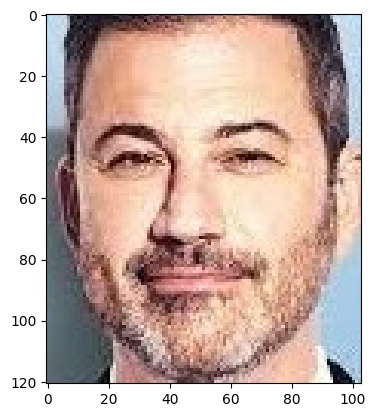

(52, 'Male')


In [20]:
img = cv2.imread('/content/JimmyKimmel.jpeg')
b,g,r = cv2.split(img)
img = cv2.merge([r,g,b])
plt.imshow(img)
plt.show()
print( find_age_gender_precropped( '/content/JimmyKimmel.jpeg' ))

## Function to detect multiple faces in a photo and provide a list of bounding boxes , age , gender

In [12]:
def find_age_gender_uncropped( img_path ):       #Maximum limiting to give only 5 images but it can handle more
  img = cv2.imread(img_path)
  b,g,r = cv2.split(img)
  img = cv2.merge([r,g,b])
  plt.figure(figsize=(10, 5))
  mt_res = detector.detect_faces(img)
  gender_mapping = ["Male", "Female"]
  return_res = []
  index = 0
  for face in mt_res:
    if index == 5:
      break
    x, y, width, height = face['box']
    center = [x+(width/2), y+(height/2)]
    max_border = max(width, height)

    left = max(int(center[0]-(max_border/2)), 0)
    right = max(int(center[0]+(max_border/2)), 0)
    top = max(int(center[1]-(max_border/2)), 0)
    bottom = max(int(center[1]+(max_border/2)), 0)

    center_img_k = img[top:top+max_border, left:left+max_border, :]
    image = tf.convert_to_tensor(center_img_k)
    image = tf.cast(image, tf.float32)
    image = image/255.
    image = tf.image.resize(image, [224,224])
    image = tf.reshape(image, [-1,224,224,3])

    pred_age = tf.round(tf.squeeze(age_net_augment.predict(image, verbose=0)), 2)
    pred_gender = gender_mapping[ int(tf.round(tf.squeeze(gen_net_utk.predict(image, verbose=0)), 2))]

    return_res.append([ [top, right, bottom, left] , int(pred_age) , pred_gender ])
    plt.subplot(4, 8, index + 1)
    index = index + 1
    plt.imshow(image[0])
    plt.title(f"Age: {int(pred_age)} \n Gender: {pred_gender[0]}")
  plt.show()
  return return_res

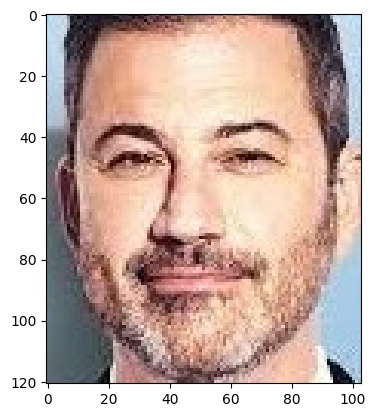

1/1 [==============================] - 0s 27ms/step


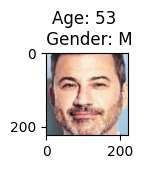

[[[3, 106, 114, 0], 53, 'Male']]

In [39]:
img = cv2.imread('/content/JimmyKimmel.jpeg')  #Though it is a cropped image Kimmel is currently 56, this image was take in recent yrs
b,g,r = cv2.split(img)
img = cv2.merge([r,g,b])
plt.imshow(img)
plt.show()
find_age_gender_uncropped('/content/JimmyKimmel.jpeg')

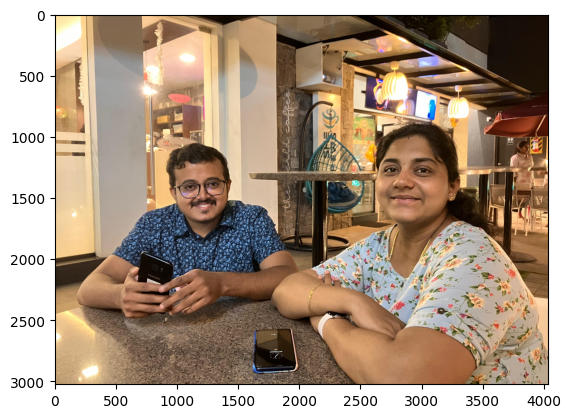

4/4 [==============================] - 0s 69ms/step


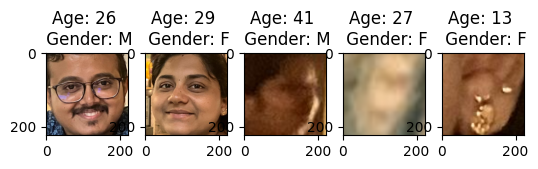

[[[1212, 1438, 1688, 962], 26, 'Male'],
 [[984, 3279, 1695, 2568], 29, 'Female'],
 [[1055, 3885, 1134, 3806], 41, 'Male'],
 [[1242, 2395, 1273, 2364], 27, 'Female'],
 [[1435, 3288, 1525, 3198], 13, 'Female']]

In [41]:
img = cv2.imread('/content/Family2.jpg')  #Seems Accurate
b,g,r = cv2.split(img)
img = cv2.merge([r,g,b])
plt.imshow(img)
plt.show()
find_age_gender_uncropped('/content/Family2.jpg')

As you can see our model has even detected far images which are completely blurred out.

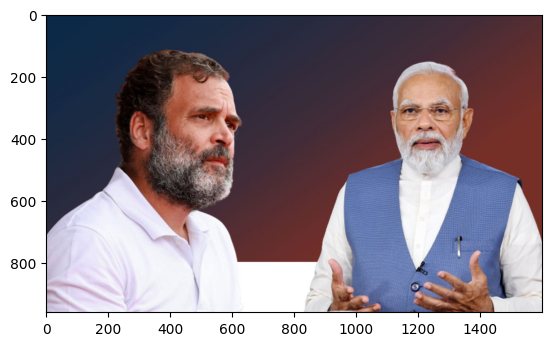

1/1 [==============================] - 0s 42ms/step


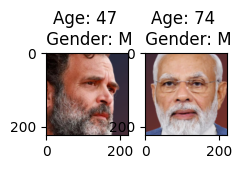

[[[193, 675, 559, 309], 47, 'Male'], [[201, 1381, 491, 1091], 74, 'Male']]

In [13]:
img = cv2.imread('/content/MRG.jpg')  #Modi: 74yrs old, Rahul Gandhi: 53 yrs old, these photos was taken in past 4 yrs
b,g,r = cv2.split(img)
img = cv2.merge([r,g,b])
plt.imshow(img)
plt.show()
find_age_gender_uncropped('/content/MRG.jpg')

**As you can see our pipeline is working very well, Lets implement the live stream  via Webcam**

## Video Streaming Web camera

### Util Snippets from Colab

In [15]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [16]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [17]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

### The following cell when Run will start a live stream via webcam


*   If the person is far, his/her photo quality will be heavily degraded, since the prior output of webcam is already poor.
*   Keeping the face in level with the webcam would give better results.
*   Avoid bright light sources as much as possible.
*   Avoid Bright light source in front of your face, which makes the model to be highly inaccurate.
*   It can detect multiple faces also at same time, the results will be overlayed on the output video stream.
*   Click on the video to stop the stream, otherwise the webcam will be on even if you cancel run of the cell.



In [37]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
results = list()
count = 0
font_scale = 0.5
thickness = 1
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray)
    #faces = detector.detect_faces(img)
    # get face bounding box for overlay
    for (x,y,w,h) in faces:
    #for face in faces:
      #x,y,w,h = face['box']
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)
      im = img[y:y+h,x:x+w]

      # b,g,r = cv2.split(img)
      # im = cv2.merge([r,g,b])
      im = tf.convert_to_tensor(im)
      im = tf.cast(im, tf.float32)
      im = im/255.
      im = tf.image.resize(im, [224,224])
      im = tf.reshape(im, [-1,224,224,3])

      age_pred = int(tf.round(tf.squeeze(age_net_augment.predict(im, verbose=0)), 2))
      gender_pred = tf.round(tf.squeeze(gen_net_utk.predict(im, verbose=0)), 2)
      gender = 'male'
      if int(gender_pred) == 1:
        gender = 'female'
      res = str( int(age_pred) ) + " " + gender
      (text_width, text_height), _ = cv2.getTextSize( res, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)
      text_x = x + 10  # Adjust the value to place the text closer or farther from the left side of the rectangle
      text_y = y - 10
      cv2.putText(bbox_array, res , (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 0, 255), thickness, cv2.LINE_AA)
      #results.extend(res)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>